# Velocity field estimation for 2D HIT using floating sensor locations
Authors: Tomoya Oura (Keio Univ.)
- This is the sample code for the velocity field estimation using floating sensor locations. 
- This notebook includes both the model training and the model evaluation.
- We provide no guarantees for this code. Use as-is and for academic research use only; no commercial use allowed without permission.
- The code is written for educational clarity and not for speed.

History:
- Version 1.0: July 12, 2025.

In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Conv2D, UpSampling2D, Reshape, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from layers import *

matplotlib style settings

In [2]:
try:
    plt.rc("font",**{"family":"sans-serif","sans-serif":["Times New Roman"]})
    plt.rc("text", usetex=True)
    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["ps.fonttype"] = 42
    plt.rc("font", family="Times New Roman")
    plt.rcParams["font.family"] = "Times New Roman"
except:
    print("Note: Font setting for matplotlib may be incomplete.")
    
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 20
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = "k"
plt.rcParams["legend.framealpha"] = 1.0

GPU seeting (if used)

In [3]:
gpu_id = 0
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.list_physical_devices("GPU")
tf.config.set_visible_devices(physical_devices[gpu_id], "GPU")
tf.config.experimental.set_memory_growth(physical_devices[gpu_id], True)

## Requirements

In [4]:
!python -V
print(tf.__version__)
print(np.__version__)
print(matplotlib.__version__)

Python 3.10.13
2.11.0
1.26.4
3.8.4


## Setting

Load training data.

In [5]:
sensor_locations_at_n = np.load("./data/sensor_locations_at_n.npy")
sensor_locations_at_n_plus_1 = np.load("./data/sensor_locations_at_n_plus_1.npy")

print(sensor_locations_at_n.shape, sensor_locations_at_n_plus_1.shape)

(2500, 512, 2) (2500, 512, 2)


Set the number of epochs.

In [6]:
epochs = 2000

## Model declaration

In [7]:
inputs = Input(
    shape=sensor_locations_at_n.shape[1:3], 
    name="input_layer")

##### Flow field estimator #####
#### MLP section
x0 = Lambda(lambda x:x[:, :, 0], name="extract_xp")(inputs)
x1 = Lambda(lambda x:x[:, :, 1], name="extract_yp")(inputs)

MLP = Sequential(
    [
        Dense(256, activation="relu"),
        Dense(256, activation="relu"),
        Dense(256, activation="relu"),
        Dense(256, activation="relu"),
    ]
)

x0 = MLP(x0)
x1 = MLP(x1)

x0 = Reshape([16, 16, 1])(x0)
x1 = Reshape([16, 16, 1])(x1)

x = Concatenate()([x0, x1])

#### CNN section
x = PeriodicPaddingLayer(padding=3)(x)
x = Conv2D(48, (7, 7), activation="relu", padding="valid")(x)
x = UpSampling2D((2, 2))(x)

x = PeriodicPaddingLayer(padding=3)(x)
x = Conv2D(48, (7, 7), activation="relu", padding="valid")(x)
x = UpSampling2D((2, 2))(x)

x = PeriodicPaddingLayer(padding=3)(x)
x = Conv2D(48, (7, 7), activation="relu", padding="valid")(x)
x = UpSampling2D((2, 2))(x)

x = PeriodicPaddingLayer(padding=3)(x)
x = Conv2D(48, (7, 7), activation="relu", padding="valid")(x)
x = UpSampling2D((2, 2))(x)

x = PeriodicPaddingLayer(padding=3)(x)
x = Conv2D(48, (7, 7), activation="relu", padding="valid")(x)
x = UpSampling2D((2, 2))(x)

x = PeriodicPaddingLayer(padding=3)(x)
x = Conv2D(48, (7, 7), activation="relu", padding="valid")(x)

x = PeriodicPaddingLayer(padding=1)(x)
ufvf_n_estimated = Conv2D(2, (3, 3), padding="valid", activation="linear", name="output_ufvf_layer")(x)

##### Sensor tracker #####
xp_n_1_estimated, yp_n_1_estimated = ParticleTrackingLayer()([inputs, ufvf_n_estimated])

In [8]:
model = Model(inputs, [xp_n_1_estimated, yp_n_1_estimated])
model.compile(optimizer="adam", loss="mse")

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 512, 2)]     0           []                               
                                                                                                  
 extract_xp (Lambda)            (None, 512)          0           ['input_layer[0][0]']            
                                                                                                  
 extract_yp (Lambda)            (None, 512)          0           ['input_layer[0][0]']            
                                                                                                  
 sequential (Sequential)        (None, 256)          328704      ['extract_xp[0][0]',             
                                                                  'extract_yp[0][0]']         

---

## Model training

In [9]:
# Save best only
model_cb = ModelCheckpoint(
    "./best_model.hdf5",
    monitor="loss",
    save_best_only=True,
    verbose=0)

# Model training
history = model.fit(
    sensor_locations_at_n,
    [sensor_locations_at_n_plus_1[:, :, 0], sensor_locations_at_n_plus_1[:, :, 1]],
    epochs=epochs,
    batch_size=64,
    verbose=0,
    callbacks=[model_cb],
    shuffle=True
    )

### Loss curve

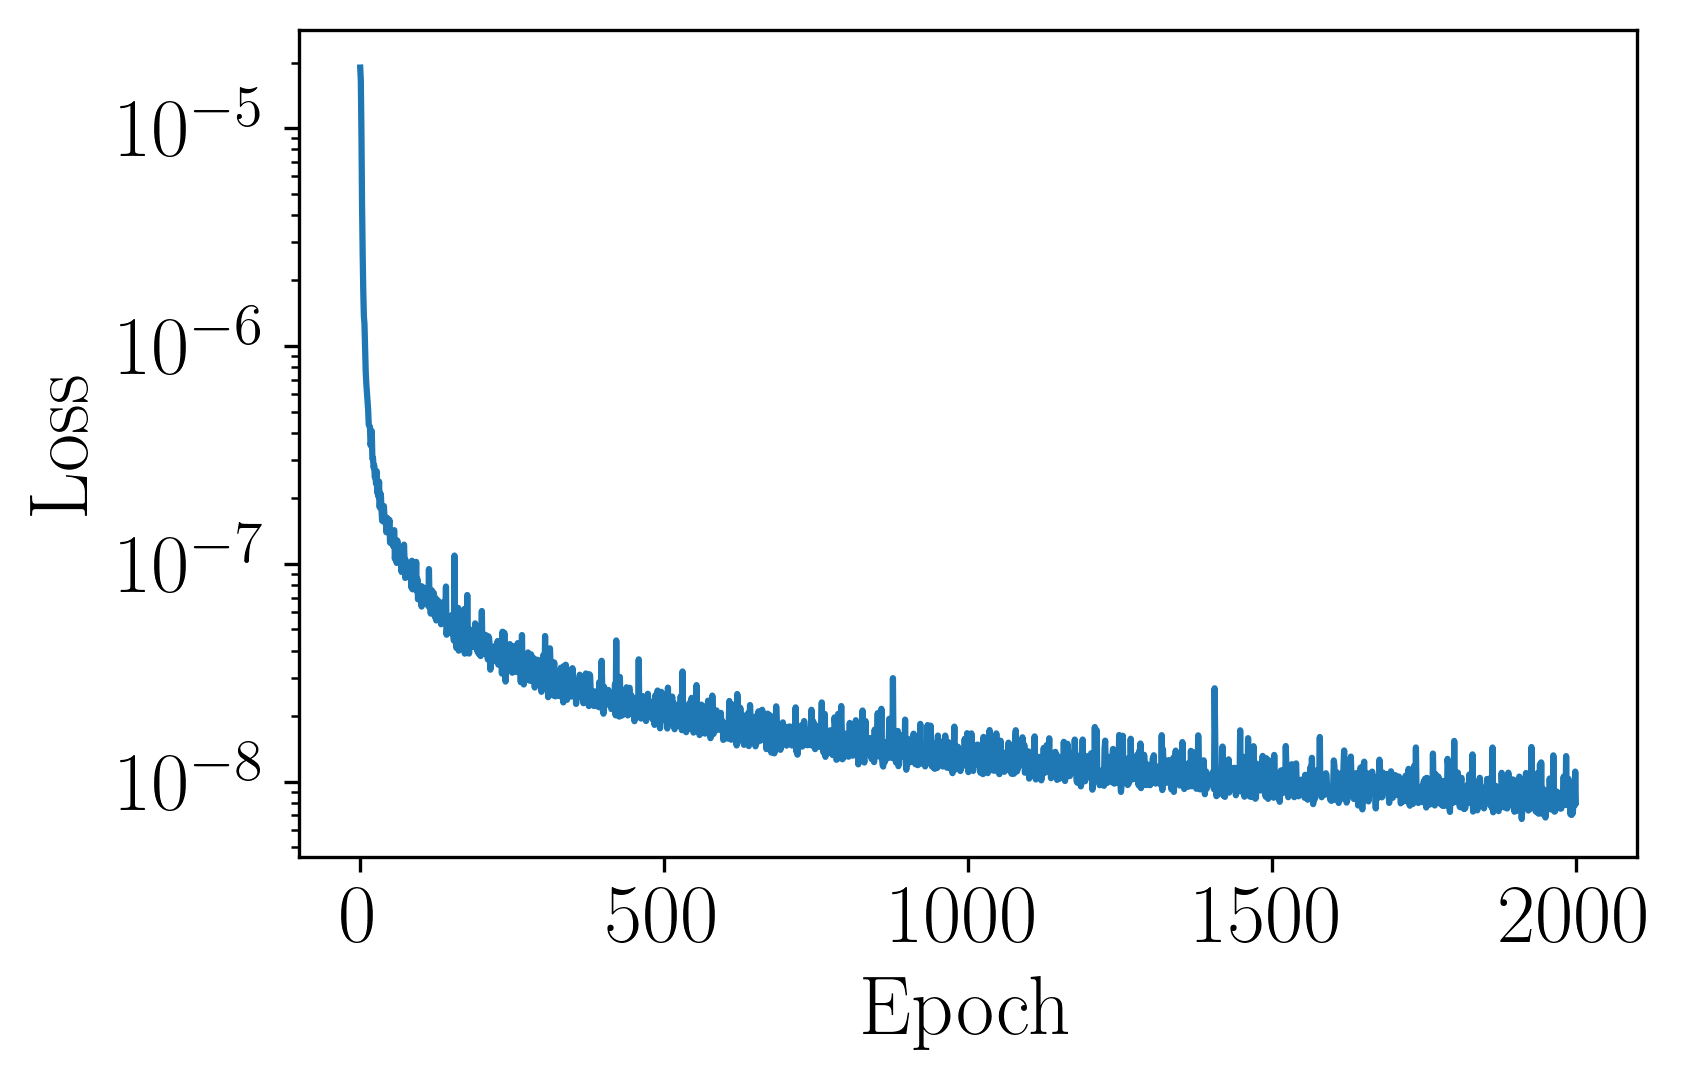

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(history.epoch, history.history["loss"], "-")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_yscale("log")
fig.tight_layout()

## Model evaluation

### Flow field estimation

Load the trained model with the best loss.

In [11]:
best_model = tf.keras.models.load_model(
    "./best_model.hdf5",
    custom_objects={
        "ParticleTrackingLayer": ParticleTrackingLayer,
        "PeriodicPaddingLayer": PeriodicPaddingLayer
    }) 

Extract the flow field estimator from the trained model.

In [12]:
output_layer = "output_ufvf_layer"

flow_field_estimator = tf.keras.Model(
    inputs=best_model.input,
    outputs=best_model.get_layer(output_layer).output,
    name="flow_field_estimator")

flow_field_estimator.trainable = False

flow_field_estimator.summary()

Model: "flow_field_estimator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 512, 2)]     0           []                               
                                                                                                  
 extract_xp (Lambda)            (None, 512)          0           ['input_layer[0][0]']            
                                                                                                  
 extract_yp (Lambda)            (None, 512)          0           ['input_layer[0][0]']            
                                                                                                  
 sequential (Sequential)        (None, 256)          328704      ['extract_xp[0][0]',             
                                                                  'extract_yp[0

Load the ground-truth field at $n =$ `n_valid` of the training dataset.

In [13]:
n_valid = 1000 # Set here.

ufvf_truth = np.load("./data/ufvf_truth_at_" + str(int(n_valid)).zfill(4) + ".npy")
print(ufvf_truth.shape)

(512, 512, 2)


Estimate velocity fields with the flow field estimator.

In [14]:
ufvf_estimated = flow_field_estimator.predict(sensor_locations_at_n)
print(ufvf_estimated.shape)

79/79 [==============================] - 6s 69ms/step
(2500, 512, 512, 2)


### Visualization

Visualization parameters

In [15]:
nx = int(512)
ny = int(512)
x_grid = np.linspace(0, 2.0 * np.pi, nx + 1)[0:nx] # [0, 2pi)
y_grid = np.linspace(0, 2.0 * np.pi, ny + 1)[0:ny] # [0, 2pi)
dx = x_grid[1] - x_grid[0]
dy = y_grid[1] - y_grid[0]
XX, YY = np.meshgrid(x_grid + dx / 2.0, y_grid + dy / 2.0)

Visualize the ground-truth & estimated fields at $n =$ `n_valid`.

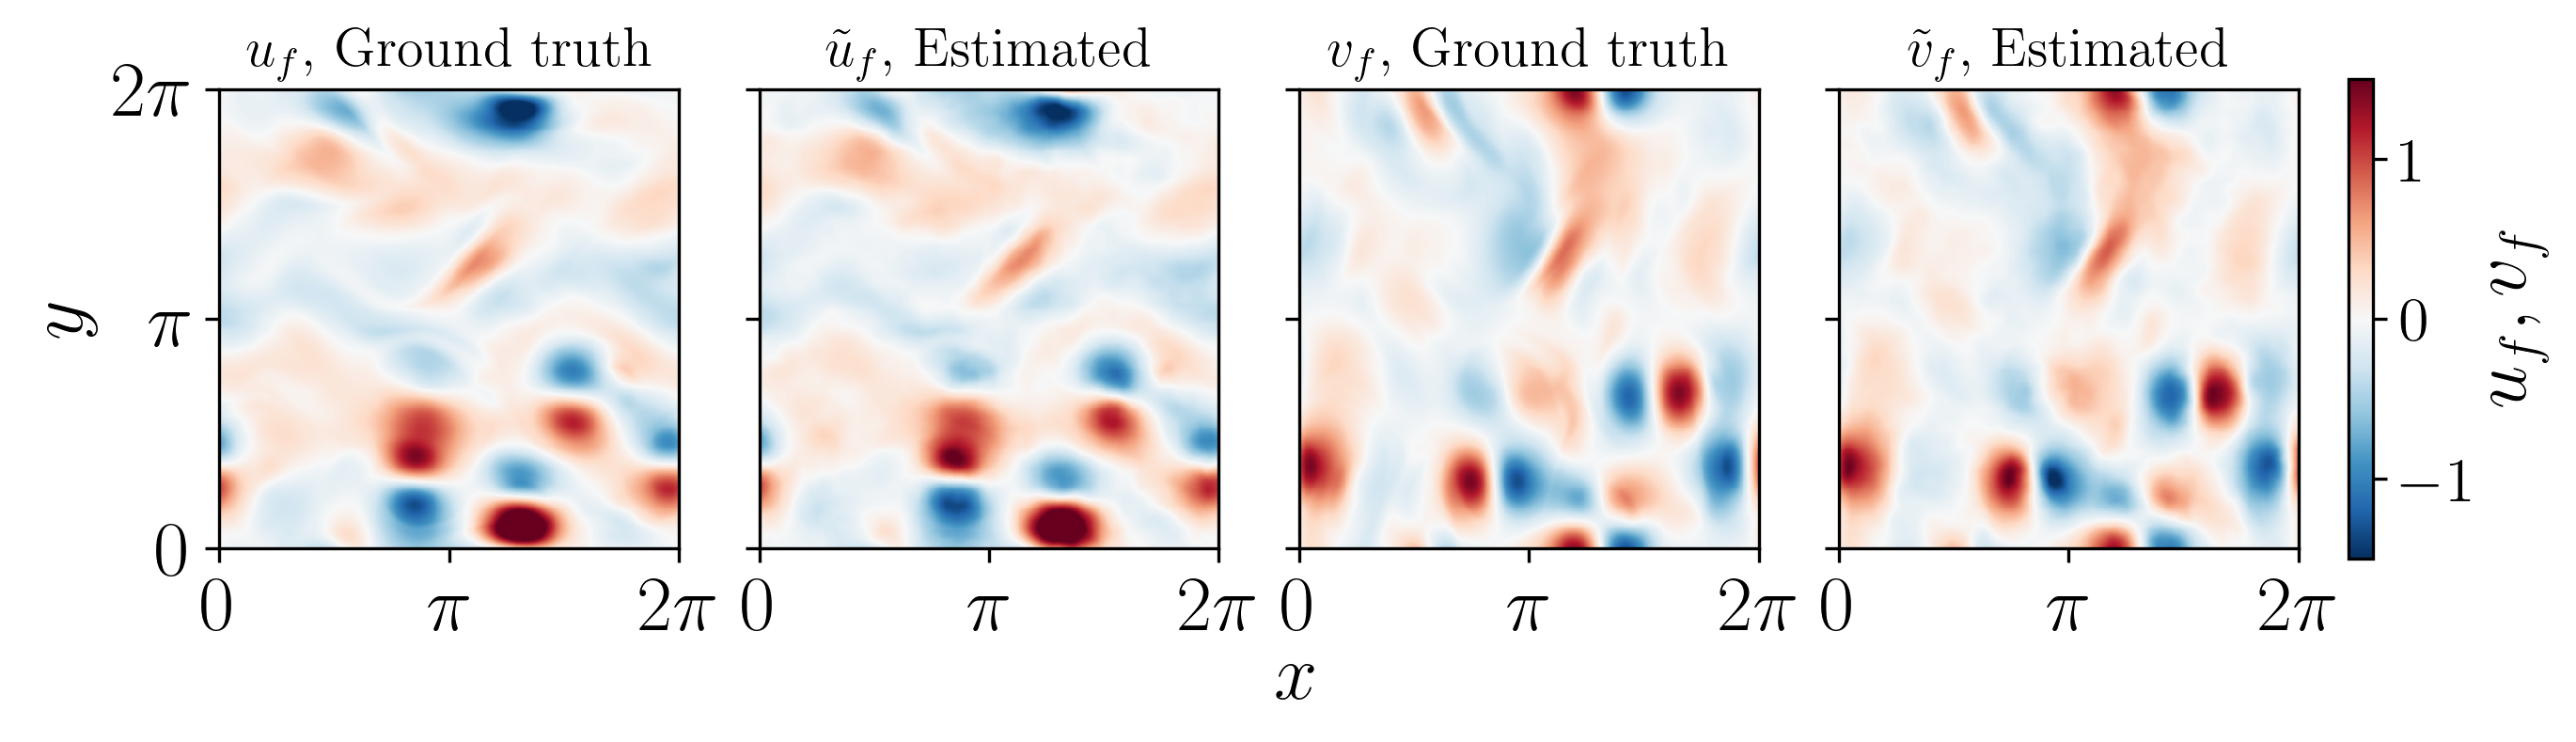

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4), sharey=True)
ax = axes.ravel()

contour = ax[0].pcolormesh(
    XX, YY, ufvf_truth[:, :, 0].T, 
    cmap="RdBu_r", vmin=-1.5, vmax=1.5,
    linewidth=0, rasterized=True)

contour = ax[1].pcolormesh(
    XX, YY, ufvf_estimated[n_valid, :, :, 0].T, 
    cmap="RdBu_r", vmin=-1.5, vmax=1.5,
    linewidth=0, rasterized=True)

contour = ax[2].pcolormesh(
    XX, YY, ufvf_truth[:, :, 1].T, 
    cmap="RdBu_r", vmin=-1.5, vmax=1.5,
    linewidth=0, rasterized=True)

contour = ax[3].pcolormesh(
    XX, YY, ufvf_estimated[n_valid, :, :, 1].T, 
    cmap="RdBu_r", vmin=-1.5, vmax=1.5,
    linewidth=0, rasterized=True)

ax[0].set_title("$u_f$, Ground truth", fontsize=14)
ax[1].set_title("$\\tilde{u}_f$, Estimated", fontsize=14)
ax[2].set_title("$v_f$, Ground truth", fontsize=14)
ax[3].set_title("$\\tilde{v}_f$, Estimated", fontsize=14)

for ax_ in ax:
    ax_.set_xlim(0, 2 * np.pi)
    ax_.set_ylim(0, 2 * np.pi)
    ax_.set_xticks([0, np.pi, 2.0 * np.pi])
    ax_.set_yticks([0, np.pi, 2.0 * np.pi])
    ax_.set_xticklabels(["0", "$\\pi$", "$2\\pi$"])
    ax_.set_yticklabels(["0", "$\\pi$", "$2\\pi$"])
    ax_.set_aspect("equal")
    
fig.tight_layout(w_pad=0.5)
fig.supxlabel("$x$", x=0.45, y=0.15, fontsize=20)
fig.supylabel("$y$", x=0.0, y=0.5, fontsize=20)

cbar = fig.colorbar(contour, pad=0.02, shrink=0.5, ax=axes, aspect=20)
cbar.ax.tick_params(labelsize=16)
cbar.set_label("$u_f, v_f$", labelpad=0)